In [14]:
from flask import Flask, render_template, request
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, OneClassSVM
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

app = Flask(__name__)
data = pd.read_csv("insurance.csv")
data.head()




,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [15]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [16]:


le=LabelEncoder()
data['sex']=le.fit_transform(data['sex'])
data['smoker']=le.fit_transform(data['smoker'])
data['region']=le.fit_transform(data['region'])
print("Encoded data")
print(data.head())



Encoded data
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


EDA part


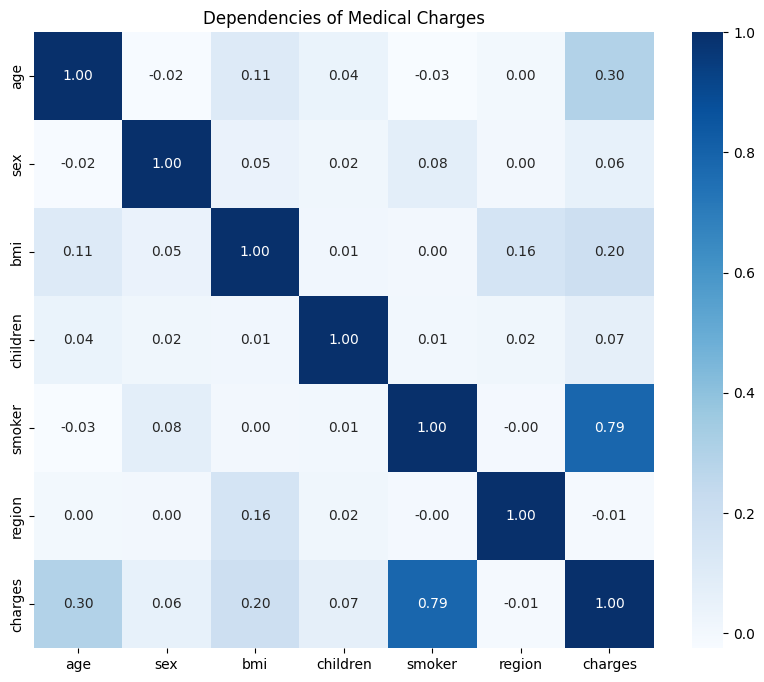

In [17]:
corr = data.corr()
import os
import seaborn as sns
os.makedirs('./sampleImages', exist_ok=True)

fig, ax=plt.subplots(figsize=(10,8))
plt.savefig('./sampleImages/heatmap')
sns.heatmap(corr,cmap='Blues',annot=True,fmt=".2f",ax=ax)
plt.title("Dependencies of Medical Charges")
plt.show()

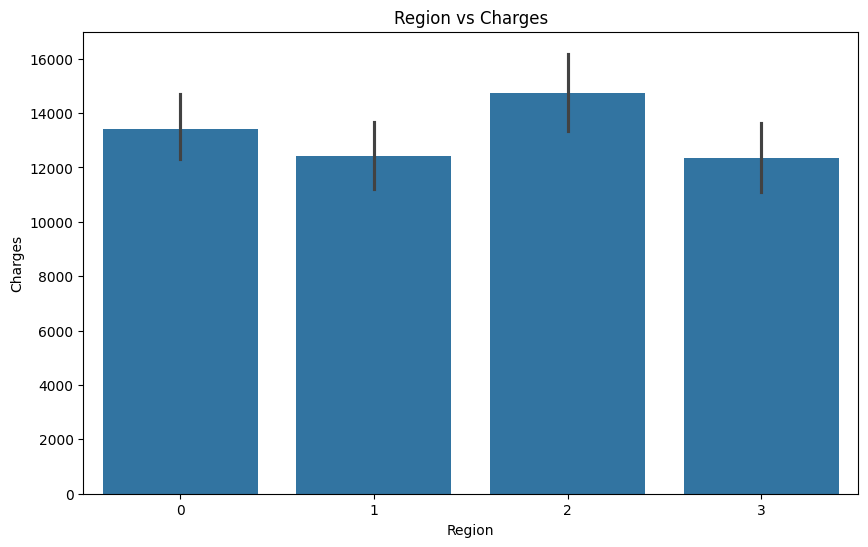

In [18]:

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', data=data)
plt.title('Region vs Charges')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

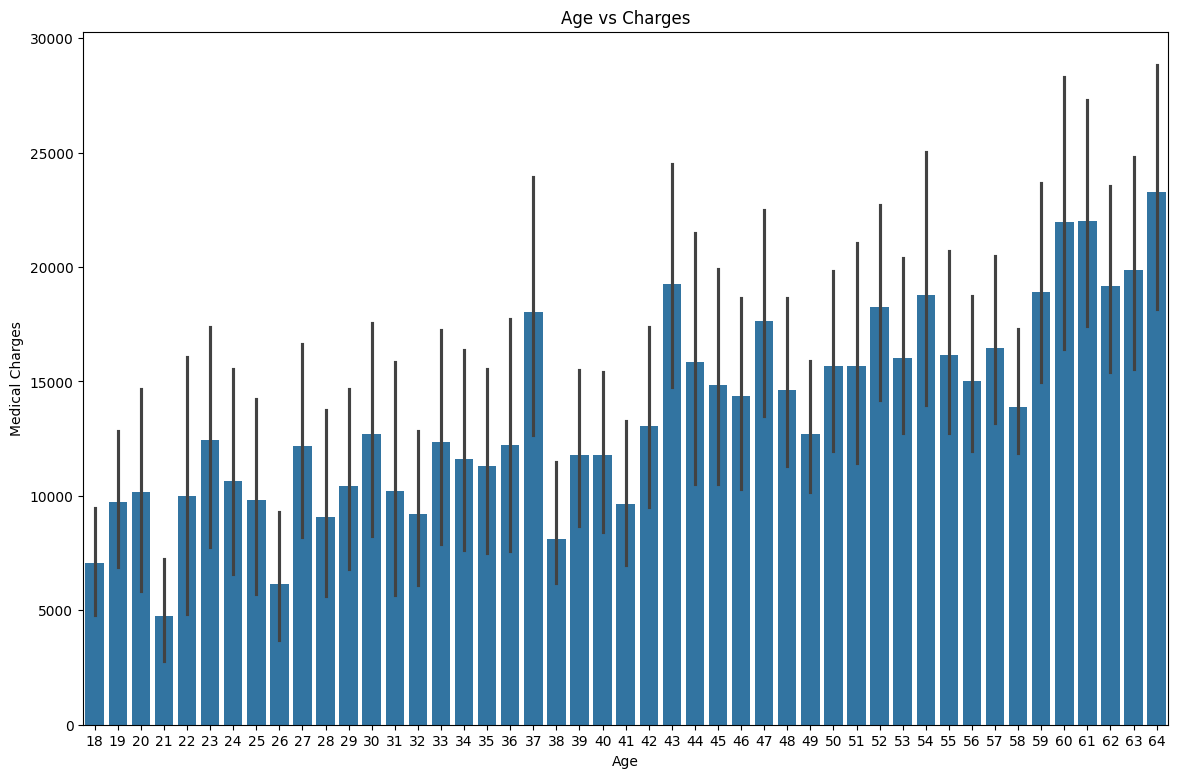

In [19]:
plt.figure(figsize=(14,9))
plt.title("Age vs Charges")
sns.barplot(x='age', y='charges', data=data)
plt.xlabel("Age")
plt.ylabel("Medical Charges")
plt.savefig('./sampleImages/AgevsCharges')
plt.show()

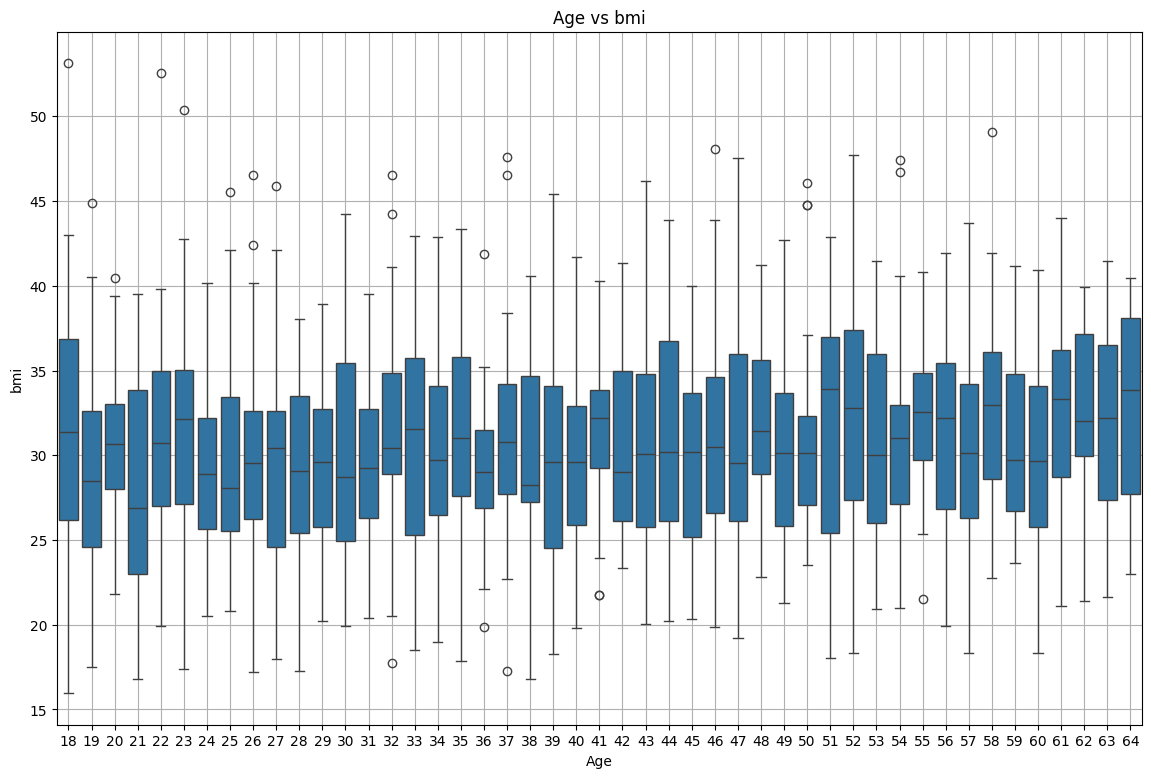

In [20]:
plt.figure(figsize=(14,9))
plt.title("Age vs bmi")
sns.boxplot(x='age', y='bmi', data=data)
plt.xlabel("Age")
plt.ylabel("bmi")
plt.grid(True)
#plt.savefig('./sampleImages/Agevsbmi')

plt.show()

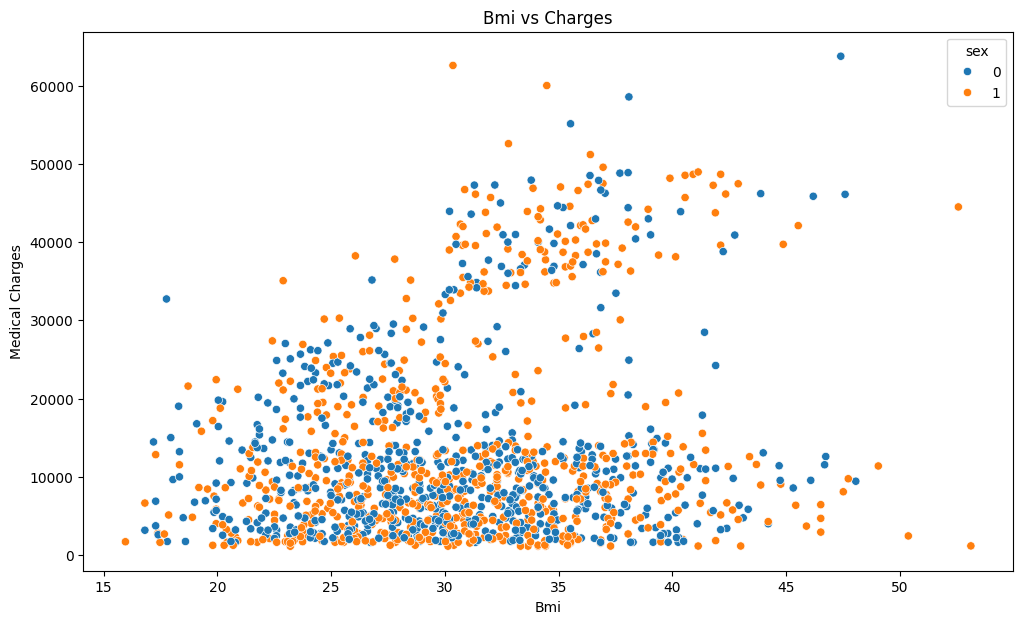

In [21]:
plt.figure(figsize=(12,7))
plt.title("Bmi vs Charges")
sns.scatterplot(x='bmi', y='charges', data=data, hue='sex')
plt.xlabel("Bmi")
plt.ylabel("Medical Charges")
plt.savefig('./sampleImages/BmivsCharges')
plt.show()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


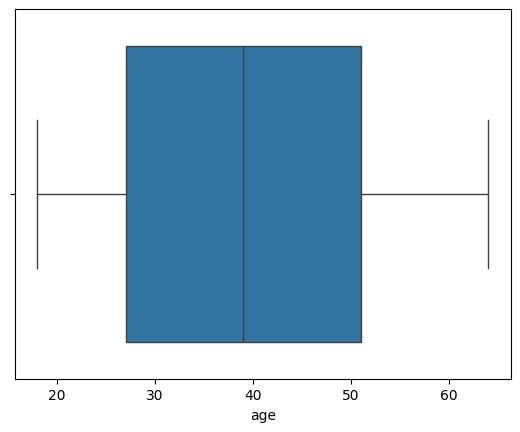

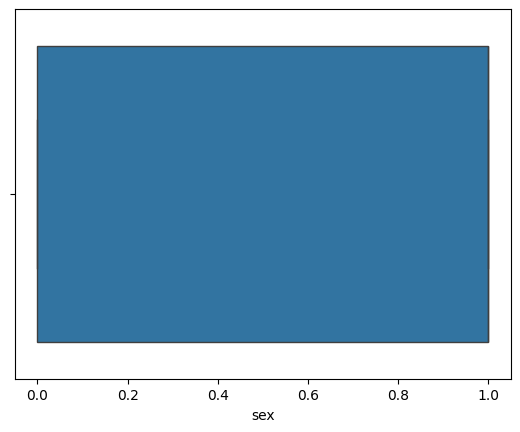

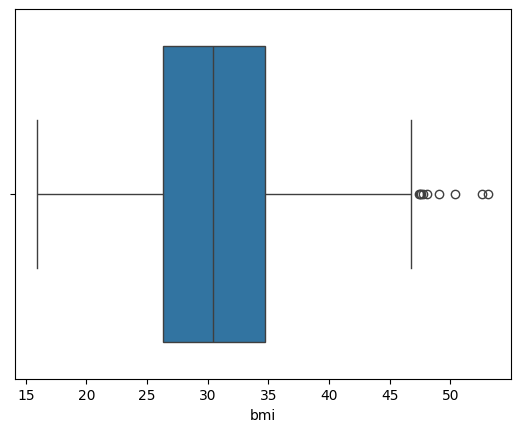

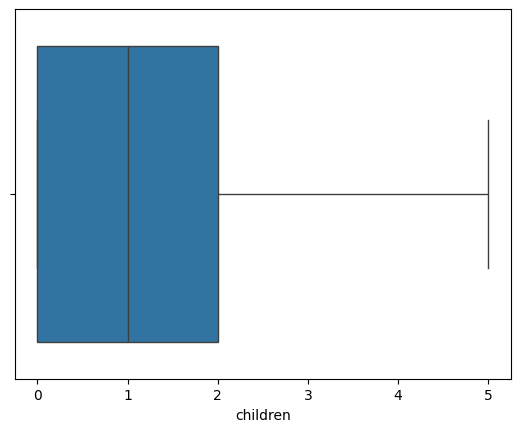

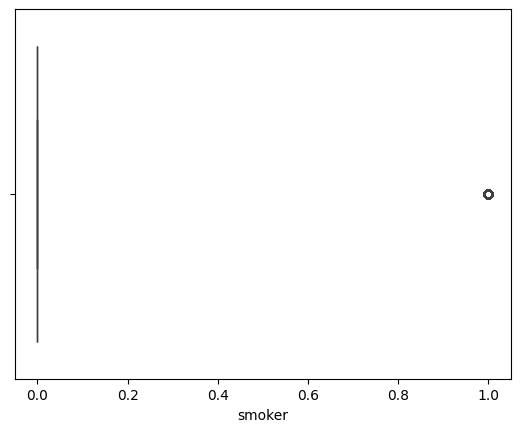

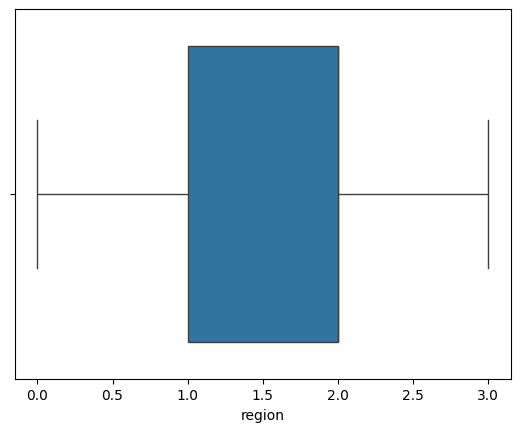

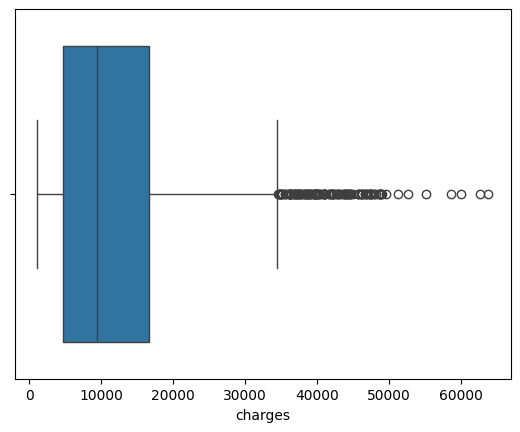

In [22]:

print(data.columns)
for datum in data.columns:
  sns.boxplot(x=data[datum],data=data)
  plt.savefig(f"./sampleImages/{datum}")
  plt.show()


data training


Outlier detection


In [23]:
X=data.values
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma="scale")
clf.fit(X)
y_pred = clf.predict(X)

# keep only the points classified as normal y_pred == 1)
X_clean = X[y_pred == 1]

cleaned_df = pd.DataFrame(X_clean, columns=data.columns)
print("Cleaned Data (No Outliers):")
print(cleaned_df)

data.to_csv('data.csv', index=False)

Cleaned Data (No Outliers):
       age  sex     bmi  children  smoker  region      charges
0     19.0  0.0  27.900       0.0     1.0     3.0  16884.92400
1     18.0  1.0  33.770       1.0     0.0     2.0   1725.55230
2     28.0  1.0  33.000       3.0     0.0     2.0   4449.46200
3     33.0  1.0  22.705       0.0     0.0     1.0  21984.47061
4     32.0  1.0  28.880       0.0     0.0     1.0   3866.85520
...    ...  ...     ...       ...     ...     ...          ...
1198  52.0  0.0  44.700       3.0     0.0     3.0  11411.68500
1199  50.0  1.0  30.970       3.0     0.0     1.0  10600.54830
1200  18.0  0.0  31.920       0.0     0.0     0.0   2205.98080
1201  21.0  0.0  25.800       0.0     0.0     3.0   2007.94500
1202  61.0  0.0  29.070       0.0     1.0     1.0  29141.36030

[1203 rows x 7 columns]


In [24]:

X = data.drop(['charges'],axis=1).values
y = data['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_test.shape)


(268,)


In [25]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#knn regressor
regressor= KNeighborsRegressor()
regressor.fit(X_train_scaled,y_train)
knn_pred=regressor.predict(X_test_scaled)


# SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

# random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

knn_r2= r2_score(y_test,knn_pred)
print(knn_r2)

svm_r2 = r2_score(y_test, svm_pred)
print(svm_r2)

rf_r2 = r2_score(y_test, rf_pred)
print(rf_r2)



0.8345213343512302
-0.06821813183902203
0.8642606273649586


In [26]:


if knn_r2 > max(svm_r2, rf_r2):
    final_model = regressor
    scaler_used = False
    predictions = knn_pred
elif svm_r2 > rf_r2:
    final_model = svm_model
    scaler_used = True
    predictions = svm_pred
else:
    final_model = rf_model
    scaler_used = False
    predictions = rf_pred


@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:

        age = int(request.form['age'])
        sex = request.form['sex']
        bmi= float(request.form['bmi'])
        smoker = request.form['smoker']
        children = int(request.form['children'])
        sex_encoded = 1 if sex == 'male' else 0
        smoker_encoded = 1 if smoker == 'yes' else 0


        input_data = pd.DataFrame([[age, sex_encoded, bmi, smoker_encoded, children]],
                                  columns=['age', 'sex', 'bmi', 'smoker', 'children'])
        if scaler_used:
            input_data_scaled = scaler.transform(input_data)
            predicted_cost = final_model.predict(input_data_scaled)[0]
        else:
            predicted_cost = final_model.predict(input_data)[0]

        return render_template('index.html',
                               predicted_cost=f"₹{predicted_cost:.2f}",
                               age=age, sex=sex, bmi=bmi, smoker=smoker, children=children)
    except Exception as e:
        return f"Error: {str(e)}"

if __name__ == '__main__':
    app.run(debug=True)





 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\Shanu Jose\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
